In [29]:
#importing libraries
import os
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate,HumanMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq
from typing import TypedDict,Dict
from langgraph.graph import StateGraph,END
from IPython.display import display,Image
from langchain_core.runnables.graph import MermaidDrawMethod,NodeStyles


In [30]:
#Loading the api key
load_dotenv()
groq_api_key=os.getenv("groq_api_key")

if groq_api_key:
    print("Groq API Key loaded succesfully")
else:
    print("Error: Groq API Key was not found")

Groq API Key loaded succesfully


#### State Structure

In [31]:
class State (TypedDict):
    query:str
    category:str
    sentiment:str
    response:str
    


In [32]:
#Defining the LLM
llm=ChatGroq(
    groq_api_key=groq_api_key,
    temperature=0,
    model_name="llama-3.3-70b-versatile"
)

#### Node Function

In [33]:
#keywords
technical_keywords = ["error", "bug", "crash", "technical issue", "problem","won't work"]
billing_keywords = ["amount","balance","invoice", "refund", "payment", "charge", "billing"]
general_keywords = ["time","deliver", "location", "info", "support", "contact"]

In [34]:
def keyword_route(query: str) -> str:
    query_lower = query.lower()
    
    if any(keyword in query_lower for keyword in technical_keywords):
        return "Technical"
    elif any(keyword in query_lower for keyword in billing_keywords):
        return "Billing"
    elif any(keyword in query_lower for keyword in general_keywords):
        return "General"
    else:
        return "Unknown"


In [35]:
#Category function
def categorize(state: State) -> State:
    query = state["query"]
    # First, trying keyword-based categorization
    category = keyword_route(query)
    # If keywords didn't match, use LLM
    if category == "Unknown":
        prompt = ChatPromptTemplate.from_template(
            "Categorize the following customer query into one of these categories: "
            "Technical, Billing, General. Query: {query}"
        )
        chain = prompt | llm
        category = chain.invoke({"query": state['query']}).content
    return {"category": category}


In [36]:
#Sentiment function
def analyze_sentiment(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | llm
    sentiment = chain.invoke({"query": state['query']}).content  
    return {"sentiment": sentiment} 


In [37]:
#Technical function
def handle_technical(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query : {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query" : state['query']}).content
    return {"response" : response}

In [38]:
#Billing function
def handle_billing(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query : {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query" : state['query']}).content
    return {"response" : response}

In [39]:
#General function
def handle_general(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query : {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query" : state['query']}).content
    return {"response" : response}

In [40]:
def escalate(state : State) -> State:
    return{"response" : "This query has been escalate to a human agent due to its negative sentiment"}

In [41]:
def route_query(state: State):
    query = state["query"]
    keyword_category = keyword_route(query)
    if state["sentiment"]=='Negative':
        return "escalate"
    # keyword route first
    if keyword_category == "Technical":
        return "handle_technical"
    elif keyword_category == "Billing":
        return "handle_billing"
    elif keyword_category == "General":
        return "handle_general"

    # Otherwise fallback to LLM-based categorization
    if state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"


#### StateGraph

In [42]:
builder= StateGraph(State)
builder.add_node("categorize", categorize)
builder.add_node("analyze_sentiment",analyze_sentiment)
builder.add_node("handle_technical", handle_technical)
builder.add_node("handle_billing", handle_billing)
builder.add_node("handle_general", handle_general)
builder.add_node("escalate", escalate)

In [43]:
#adding edges
builder.add_edge("categorize", "analyze_sentiment")
builder.add_conditional_edges("analyze_sentiment", 
route_query,{
    "handle_technical" : "handle_technical",
    "handle_billing": "handle_billing",
    "handle_general" : "handle_general",
    "escalate": "escalate"
})
builder.add_edge("handle_technical", END)
builder.add_edge("handle_billing", END)
builder.add_edge("handle_general", END)
builder.add_edge("escalate", END)

In [44]:
#Entry point
builder.set_entry_point("categorize")

In [45]:
#Compiling
app=builder.compile()

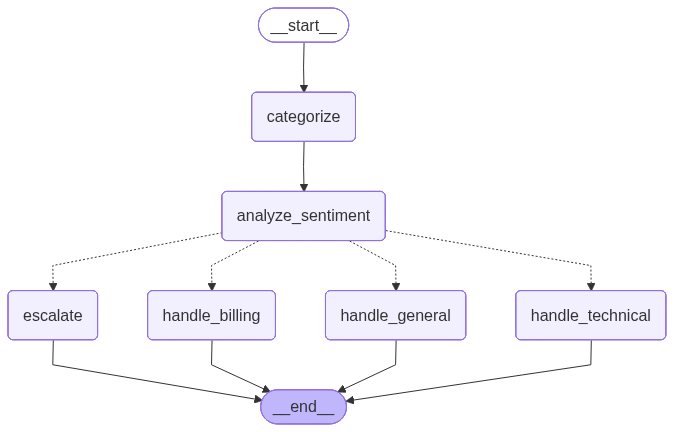

In [46]:
#vizualise the graph
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )

))

In [47]:
mermaid_code = app.get_graph().draw_mermaid(
    node_colors=NodeStyles(default="purple")
)
print(mermaid_code)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	categorize(categorize)
	analyze_sentiment(analyze_sentiment)
	handle_technical(handle_technical)
	handle_billing(handle_billing)
	handle_general(handle_general)
	escalate(escalate)
	__end__([<p>__end__</p>]):::last
	__start__ --> categorize;
	analyze_sentiment -.-> escalate;
	analyze_sentiment -.-> handle_billing;
	analyze_sentiment -.-> handle_general;
	analyze_sentiment -.-> handle_technical;
	categorize --> analyze_sentiment;
	escalate --> __end__;
	handle_billing --> __end__;
	handle_general --> __end__;
	handle_technical --> __end__;
	classDef default purple
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



#### CUSTOMER SUPPORT FUNCTION

In [48]:
def run_customer_support(query: str) -> dict:
    result = app.invoke({"query": query})
    return {
        "category": result.get('category', 'Unknown'),
        "sentiment": result.get('sentiment', 'Neutral'),
        "response": result.get('response', 'No response')
    }


In [49]:
#Testing
query = "How long will the delivery take?"
result = run_customer_support(query)

print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")



Query: How long will the delivery take?
Category: General
Sentiment: Neutral. The customer is seeking information about the delivery time, but there is no emotional tone or language indicating satisfaction, dissatisfaction, or any other sentiment.
Response: Thank you for reaching out to us about your delivery. The delivery time for your order may vary depending on your location and the shipping method you've chosen. 

Typically, our standard delivery takes between 3-7 business days, while our express delivery option can take as little as 1-3 business days. However, please note that these times are estimates and may be affected by factors such as weather conditions, traffic, and the efficiency of our courier services.

To get a more accurate estimate of your delivery time, I recommend checking your order confirmation email for the tracking details. You can use the tracking number to monitor the status of your package on the courier's website.

If you have any further questions or concer

In [50]:
#Testing
query = "I have not received any good services"
result = run_customer_support(query)

print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


Query: I have not received any good services
Category: I would categorize the customer query as "General". The query is a broad complaint about the quality of service received, but it does not specifically mention a technical issue or a billing problem. It is a general expression of dissatisfaction with the service.
Sentiment: Negative
Response: This query has been escalate to a human agent due to its negative sentiment


In [51]:
#Testing
query = "I want to make an order"
result = run_customer_support(query)

print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


Query: I want to make an order
Category: I would categorize the query "I want to make an order" as General. This is because the customer is expressing a desire to place an order, but is not asking a specific technical question or inquiring about billing. The query is more related to the overall process or procedure of making a purchase.
Sentiment: Neutral.
Response: Thank you for considering making an order with us. We're excited to help you with your purchase. To get started, could you please provide us with some more information about what you're looking to order? This will help us to better assist you and ensure that we can fulfill your request as quickly and efficiently as possible.

You can reach out to us through this chat or visit our website to browse our products and services. We're here to help and look forward to hearing from you soon.

Some questions to consider when placing your order:

* What product or service are you interested in ordering?
* What quantity would you lik

In [52]:
#Testing
query = "I am happy with your services"
result = run_customer_support(query)

print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


Query: I am happy with your services
Category: I would categorize the query as "General". The customer is expressing satisfaction with the services, but is not asking a specific technical question or inquiring about billing. It's a general statement of appreciation.
Sentiment: Positive
Response: Thank you so much for taking the time to share your positive experience with us. We're thrilled to hear that you're happy with our services. Our team works hard to provide the best possible support, and it's great to know that we're meeting your expectations. If you have any other questions or need assistance in the future, don't hesitate to reach out. We're always here to help. Thank you again for your kind words, and we look forward to continuing to serve you.
